# FSRS4Anki v6.1.2 Simulator

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-spaced-repetition/fsrs4anki/blob/v6.1.2/fsrs4anki_simulator.ipynb)

↑ Click the above button to open the simulator on Google Colab.

> If you can't see the button and are located in the Chinese Mainland, please use a proxy or VPN.

In [ ]:
# Here are some settings that you need to replace before running this optimizer.

filename = "collection-2022-09-18@13-21-58.colpkg"
# If you upload deck file, replace it with your deck filename. E.g., ALL__Learning.apkg
# If you upload collection file, replace it with your colpkg filename. E.g., collection-2022-09-18@13-21-58.colpkg

# Replace it with your timezone. I'm in China, so I use Asia/Shanghai.
# You can find your timezone here: https://gist.github.com/heyalexej/8bf688fd67d7199be4a1682b3eec7568
timezone = 'Asia/Shanghai'

# Replace it with your Anki's setting in Preferences -> Scheduling.
next_day_starts_at = 4

# Replace it if you don't want the optimizer to use the review logs before a specific date.
revlog_start_date = "2006-10-05"  # YYYY-MM-DD

# parameters for FSRS
params = [0.212, 1.2931, 2.3065, 8.2956, 6.4133, 0.8334, 3.0194, 0.001, 1.8722, 0.1666, 0.796, 1.4835, 0.0614, 0.2629, 1.6483, 0.6014, 1.8729, 0.5425, 0.0912, 0.0658, 0.1542]
desired_retention = 0.85  # recommended setting: 0.7 ~ 0.9


# common parameters
maximum_interval = 36500
new_cards_limits = 20
review_limits = 400
max_time_limts = 10000
learn_days = 300
deck_size = 20000

# Set it to True if you don't want the optimizer to use the review logs from suspended cards.
filter_out_suspended_cards = False

# Red: 1, Orange: 2, Green: 3, Blue: 4, Pink: 5, Turquoise: 6, Purple: 7
# Set it to [1, 2] if you don't want the optimizer to use the review logs from cards with red or orange flag.
filter_out_flags = []

schedulers = ["anki", "fsrs"] # You can disable anki by removing it from this list

In [ ]:
%pip install -q fsrs_optimizer==6.1.4
import numpy as np

# for local development
# import os
# import sys
# sys.path.insert(0, os.path.abspath('../fsrs-optimizer/src/fsrs_optimizer/'))
import fsrs_optimizer as optimizer

optimizer = optimizer.Optimizer()
optimizer.anki_extract(filename, filter_out_suspended_cards, filter_out_flags)
optimizer.create_time_series(timezone, revlog_start_date, next_day_starts_at, analysis=False)

Note: you may need to restart the kernel to use updated packages.
Deck file extracted successfully!
revlog.csv saved.


  0%|          | 0/9793 [00:00<?, ?it/s]

Trainset saved.


scheduler:  anki
learned cards:  6000.0
time in minutes:  102097.4
remembered cards:  5760
time per remembered card: 1.77

scheduler:  fsrs
learned cards:  6000.0
time in minutes:  81250.1
remembered cards:  5567
time per remembered card: 1.46



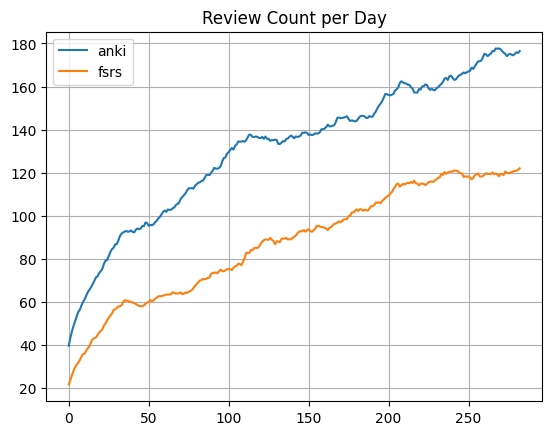

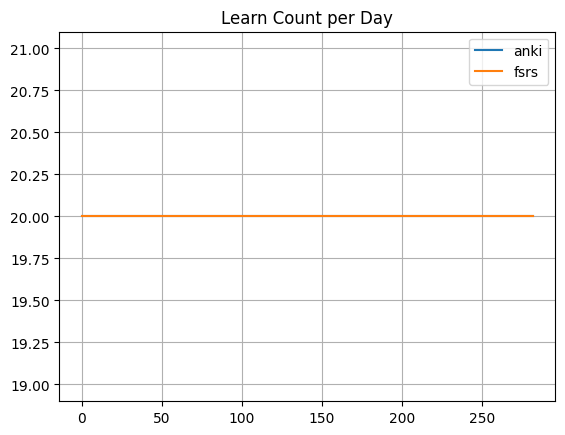

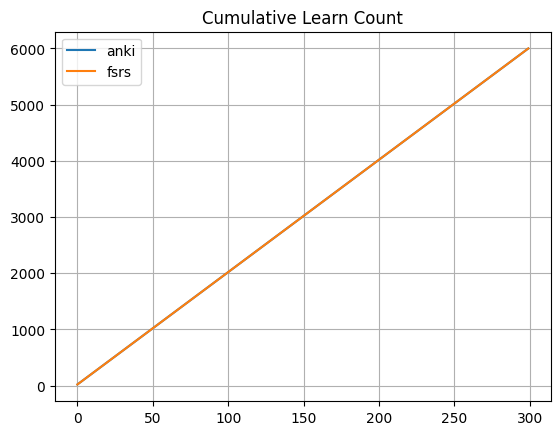

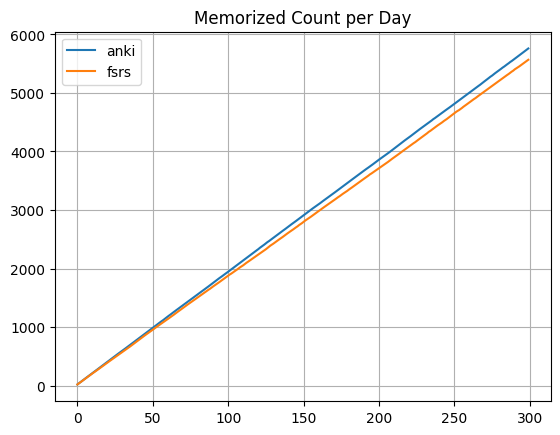

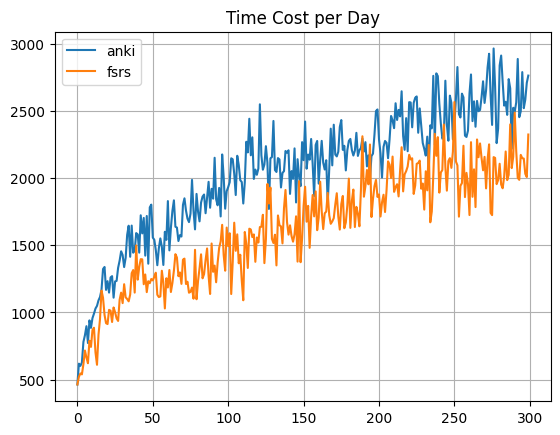

In [ ]:
from matplotlib import pyplot as plt
from fsrs_optimizer import simulate

for scheduler_name in schedulers:
    (
        card_table,
        review_cnt_per_day,
        learn_cnt_per_day,
        memorized_cnt_per_day,
        cost_per_day,
        _,
    ) = simulate(
        w=params,
        request_retention=desired_retention,
        deck_size=deck_size,
        learn_span=learn_days,
        max_cost_perday=max_time_limts,
        learn_limit_perday=new_cards_limits,
        review_limit_perday=review_limits,
        max_ivl=maximum_interval,
        first_rating_prob=optimizer.first_rating_prob,
        review_rating_prob=optimizer.review_rating_prob,
        learning_step_transitions=optimizer.learning_step_transitions,
        relearning_step_transitions=optimizer.relearning_step_transitions,
        state_rating_costs=optimizer.state_rating_costs,
        scheduler_name=scheduler_name,
    )

    def moving_average(data, window_size=365 // 20):
        weights = np.ones(window_size) / window_size
        return np.convolve(data, weights, mode="valid")

    plt.figure(1)
    plt.plot(
        moving_average(review_cnt_per_day),
        label=scheduler_name,
    )
    plt.title("Review Count per Day")
    plt.legend()
    plt.grid(True)

    plt.figure(2)
    plt.plot(
        moving_average(learn_cnt_per_day),
        label=scheduler_name,
    )
    plt.title("Learn Count per Day")
    plt.legend()
    plt.grid(True)

    plt.figure(3)
    plt.plot(
        np.cumsum(learn_cnt_per_day),
        label=scheduler_name,
    )
    plt.title("Cumulative Learn Count")
    plt.legend()
    plt.grid(True)

    plt.figure(4)
    plt.plot(
        memorized_cnt_per_day,
        label=scheduler_name,
    )
    plt.title("Memorized Count per Day")
    plt.legend()
    plt.grid(True)

    plt.figure(5)
    plt.plot(
        cost_per_day,
        label=scheduler_name,
    )
    plt.title("Time Cost per Day")
    plt.legend()
    plt.grid(True)

    total_learned = sum(learn_cnt_per_day)
    total_time = sum(cost_per_day)
    total_remembered = memorized_cnt_per_day[-1]

    print("scheduler: ", scheduler_name)
    print("learned cards: ", total_learned)
    print("time in minutes: ", round(total_time / 6, 1))
    print("remembered cards: ", round(total_remembered))
    print("time per remembered card:", round(total_time / 60 / total_remembered, 2))
    print()